In [184]:
from diffusers import StableDiffusionPipeline
import torch
from torchvision import transforms
from genaibook.core import load_image, show_image, show_images, SampleURL, get_device, image_grid

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pipe = StableDiffusionPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    variant="fp16",
).to(device)

Loading pipeline components...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.02it/s]


### Text Encoder

In [16]:
prompt = "A photograph of a puppy"

# Turn the text into a sequence of tokens:
text_input = pipe.tokenizer(prompt, return_tensors="pt")

# Output each token and its corresponding ID
for t in text_input["input_ids"][0]:
    print(t, pipe.tokenizer.decoder.get(int(t)))

tensor(49406) <|startoftext|>
tensor(320) a</w>
tensor(8853) photograph</w>
tensor(539) of</w>
tensor(320) a</w>
tensor(6829) puppy</w>
tensor(49407) <|endoftext|>


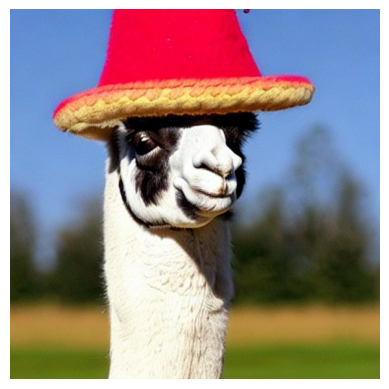

In [17]:
im = load_image(
    SampleURL.LlamaExample,
    size=(512, 512),
)
show_image(im);

In [180]:
with torch.inference_mode():
    # Process image
    tensor_im = transforms.ToTensor()(im).unsqueeze(0).to(device) * 2 - 1
    tensor_im = tensor_im.half()

    # Encode the image
    latent = pipe.vae.encode(tensor_im)

    # Sample from the latent distribution
    latents = latent.latent_dist.sample()
    latents = latents * 0.18215

latents.shape

torch.Size([1, 4, 64, 64])

### Encoded Image

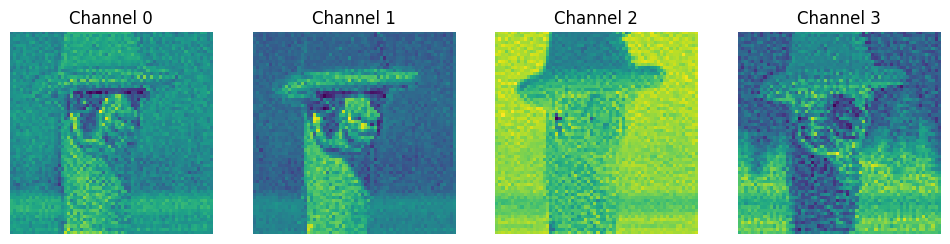

In [181]:
show_images(
    [l for l in latents[0]],
    titles=[f"Channel {i}" for i in range(latents.shape[1])],
    ncols=4,
)

### Decoded Image

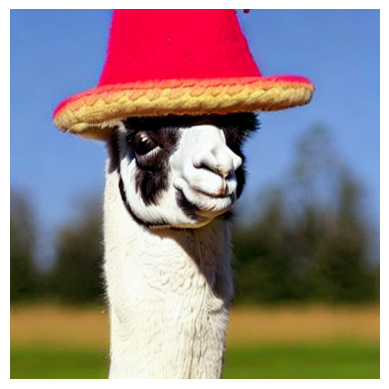

In [182]:
with torch.inference_mode():
    image = pipe.vae.decode(latents / 0.18215).sample
    
image = (image / 2 + 0.5).clip(0, 1).squeeze().float()

show_image(image);

### CFG

In [188]:
images = []
prompt = "An oil painting of a collie in a top hat"
for guidance_scale in [1, 2, 4, 12]:
    torch.manual_seed(0)
    image = pipe(prompt, guidance_scale=guidance_scale).images[0]
    images.append(image)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.65it/s]


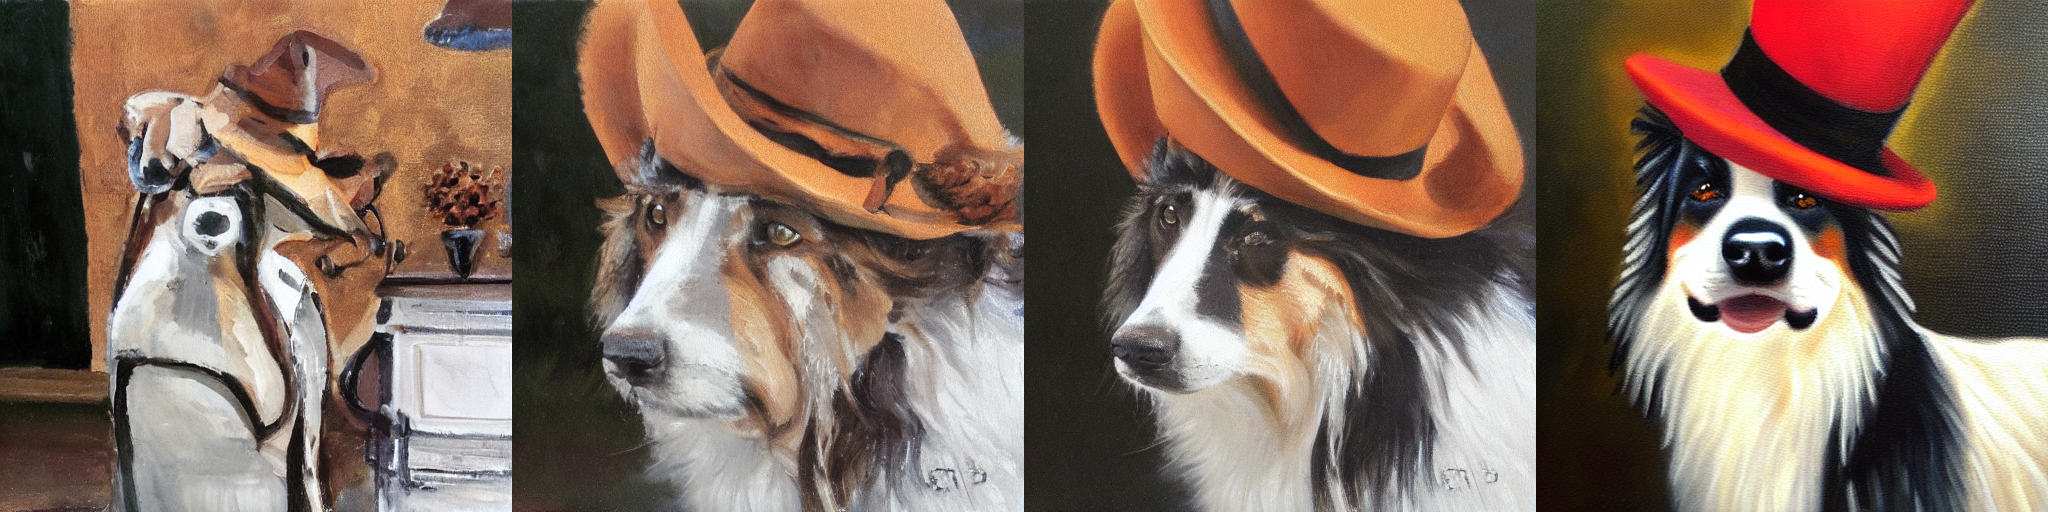

In [189]:
image_grid(images, 1, 4)

### Without Pipeline

In [190]:
# Some settings
prompt = [
    "Acrylic palette knife painting of a flower"
]  # What we want to generate
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 30  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
seed = 42  # Seed for random number generator

### All Together

In [209]:
# Some settings
prompt = ["Acrylic palette knife painting of a flower"]  # What we want to generate
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 30  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
seed = 42  # Seed for random number generator

In [210]:
# Tokenize the input
text_input = pipe.tokenizer(
    prompt,
    padding="max_length",  # Pad to max length to ensure inputs have same shape
    return_tensors="pt",
)

# Do the same for the unconditional input (a blank string)
uncond_input = pipe.tokenizer(
    "",
    padding="max_length",
    return_tensors="pt",
)

# Feed both embeddings through the text encoder
with torch.inference_mode():
    text_embeddings = pipe.text_encoder(text_input.input_ids.to(device))[0]
    uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(device))[0]

# Concatenate the two sets of text embeddings embeddings
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [211]:
text_embeddings.shape

torch.Size([2, 77, 768])

In [251]:
# Prepare the scheduler
pipe.scheduler.set_timesteps(num_inference_steps)

# Prepare the random starting latents
latents = (
    torch.randn(
        (1, pipe.unet.config.in_channels, height // 8, width // 8),
    )
    .to(device)
    .half()
)
latents = latents * pipe.scheduler.init_noise_sigma

In [252]:
latents.shape

torch.Size([1, 4, 64, 64])

In [253]:
for t in pipe.scheduler.timesteps:
    # Create two copies of the latents to match the two
    # text embeddings (unconditional and conditional)
    latent_input = torch.cat([latents] * 2)
    latent_input = pipe.scheduler.scale_model_input(latent_input, t)

    # Predict noise residuals for both unconditional and conditional latents
    with torch.inference_mode():
        noise_pred = pipe.unet(
            latent_input, t, encoder_hidden_states=text_embeddings
        ).sample

    # Split the prediction into unconditional and conditional versions
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)

    # Perform classifier-free guidance
    # https://github.com/huggingface/diffusers/blob/fdcbbdf0bb4fb6ae3c2b676af525fced84aa9850/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py#L1048
    noise_pred = noise_pred_uncond + guidance_scale * (
        noise_pred_text - noise_pred_uncond
    )

    # Update latents for the next timestep
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

In [254]:
latents.shape

torch.Size([1, 4, 64, 64])

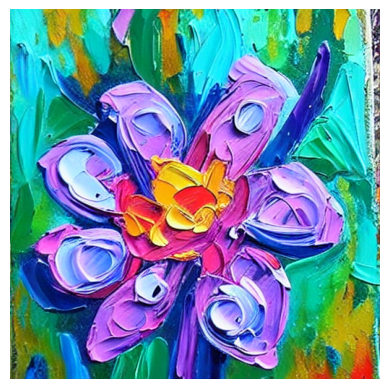

In [271]:
# Scale and decode the image latents with the VAE
# latents_out = 1 / pipe.vae.config.scaling_factor * latents
latents_out = latents / pipe.vae.config.scaling_factor

with torch.inference_mode():
    image = pipe.vae.decode(latents_out).sample

image_out = (image / 2 + 0.5).clamp(0, 1)
show_image(image_out[0].float());